In [1]:
from __future__ import absolute_import, division, print_function
import os
from scipy.io import loadmat
import arff
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib


from sklearn.svm import NuSVC, SVC
from sklearn.svm import libsvm
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

## Feature Paths

In [2]:
FBANK_feat = os.path.join('FBANK','binnedFeat.mat')
FBANK_label = os.path.join('FBANK','binnedLabels.csv')
ComParE_feat = os.path.join('baseline','openSMILEall_PCG.mat')
BOAW_feat = os.path.join('baseline_boaw','feat','boawFeat.4096.arff')
BOAW_meta = os.path.join('baseline_boaw','feat','BOAW_filenames.txt')

In [3]:
def severe2abnormal(labels):
    for idx,each in enumerate(labels):
        if each == 2:
            labels[idx]=1
    return labels

## Data Loading

In [4]:
## Load BoaW fixed

foldnum = 0
codebook = 4096
feat_path = os.path.join('baseline_boaw/feat/')
meta_path = os.path.join('..','..','feature','mfcc')


scaler = StandardScaler()

X = []
y = []
filenames = []

for subset in ['train','dev']:
    BOAW_feat = os.path.join(feat_path,
                             'fold%d.%s.%d.arff' % (foldnum,subset,codebook))
    BOAW_meta = os.path.join(meta_path,'fold%d.%s.filenames.txt' % (foldnum,subset))
    print(BOAW_feat)
    print(os.path.isfile(BOAW_meta))
    
    df = arff.load(open(BOAW_feat,'r'))
    boawData = pd.DataFrame(np.array(df['data'],dtype=float))
    del df

    boawFilenames = []
    with open(BOAW_meta, 'r') as fp:
        line = fp.readline()
        boawFilenames.append(line.split('\n')[0])
        while line:
                line = fp.readline()
                boawFilenames.append(line.split('\n')[0])
    boawFilenames = boawFilenames[:-1]
    boawData['filenames'] = boawFilenames
    boawData.rename({len(boawData.columns)-2:'label'},axis='columns',inplace=True)
    boawData.label = [int(each) for each in boawData.label]
    boawData['dataset'] = [each[-1][0] for each in boawData.filenames.str.split('_')]
    boawData.set_index('filenames',drop=True,inplace=True)
    
    filenames.append(boawFilenames)
    del boawFilenames
    
    X.append(boawData[range(4096)].values)
    y.append(boawData.label.values)
    
    del boawData
    
    
## Append INTERSPEECH with fold1 codebook

BOAW_feat = os.path.join(feat_path,
                         'interspeech.%d.arff' % (codebook))
BOAW_meta = os.path.join(meta_path,'interspeech.filenames.txt')
print(BOAW_feat)
print(os.path.isfile(BOAW_feat))

df = arff.load(open(BOAW_feat,'r'))
boawData = pd.DataFrame(np.array(df['data'],dtype=float))
del df

boawFilenames = []
with open(BOAW_meta, 'r') as fp:
    line = fp.readline()
    boawFilenames.append(line.split('\n')[0])
    while line:
            line = fp.readline()
            boawFilenames.append(line.split('\n')[0])
boawFilenames = boawFilenames[:-1]
boawData['filenames'] = boawFilenames
boawData.rename({len(boawData.columns)-2:'label'},axis='columns',inplace=True)
boawData.label = [int(each) for each in boawData.label]
boawData['dataset'] = [each[-1][0] for each in boawData.filenames.str.split('_')]
boawData.set_index('filenames',drop=True,inplace=True)

filenames.append(boawFilenames)
del boawFilenames

X.append(boawData[range(4096)].values)
y.append(boawData.label.values)

del boawData

    
X = np.vstack(X)
y = np.hstack(y)
filenames = np.hstack(filenames)

boawData = pd.DataFrame(X)
boawData['filenames'] = filenames
boawData['label'] = y
boawData.set_index('filenames',drop=True,inplace=True)
boawData['dataset'] = [each[-1][0] for each in boawData.index.str.split('_')]


del X,y

baseline_boaw/feat/fold0.train.4096.arff
True
baseline_boaw/feat/fold0.dev.4096.arff
True
baseline_boaw/feat/interspeech.4096.arff
True


In [5]:
## Load FBANK: 

df = loadmat(FBANK_feat)
fbankData = pd.DataFrame(df['feats'])
fbankMeta = pd.read_csv(FBANK_label)
fbankMeta.file_name = [each[0] for each in fbankMeta.file_name.str.split('.')]
fbankData = fbankData.join(fbankMeta)
fbankData.dropna(inplace=True)
fbankData.rename({'file_name':'filenames'},axis="columns",inplace=True)
fbankData.label = [int(each) for each in fbankData.label]
fbankData['dataset'] = [each[-1][0] for each in fbankData.filenames.str.split('_')]
fbankData.set_index('filenames',drop=True,inplace=True)

del df, fbankMeta

fbankData.shape

(3835, 2709)

In [6]:
## Load ComParE:

df = loadmat(ComParE_feat)

compareData = pd.DataFrame(df['dataTrain'])
compareData = pd.concat((compareData,pd.DataFrame(df['dataDev'])),axis="rows").reset_index(drop=True)
compareData['label'] = np.concatenate((np.hstack(df['TrainLabels']),np.hstack(df['DevLabels'])),axis=0)
compareData['filenames'] = np.concatenate((np.hstack(df['TrainFiles']),np.hstack(df['DevFiles'])),axis=0)
compareData.filenames = [each[0] for each in compareData.filenames.str.split('.')]
compareData.label = [int(each) for each in compareData.label]
compareData['dataset'] = [each[-1][0] for each in compareData.filenames.str.split('_')]
compareData.set_index('filenames',drop=True,inplace=True)

del df

compareData.shape

(3835, 6375)

In [7]:
## Fuse dataframes

print("Target Size %d" % (len(boawData.columns)-2+len(fbankData.columns)-2+len(compareData.columns)))
fused = boawData[range(len(boawData.columns)-2)].join(fbankData[range(len(fbankData.columns)-2)],rsuffix='fbank')
fused = fused.join(compareData,lsuffix='fused')
fused.dropna()
fused.columns = range(len(fused.columns))
fused.rename({len(fused.columns)-2:'label',len(fused.columns)-1:'dataset'},axis="columns",inplace=True)

del boawData, fbankData, compareData

fused.shape

Target Size 13178


(3835, 13178)

### Random Validation Split

In [ ]:
rand_state = 114
n_estimators = 10
dataset = '0'

scaler = StandardScaler()
mask = fused.dataset == dataset

X = scaler.fit_transform(fused[range(len(fused.columns)-2)][mask]) ## .4489999
y = fused.label[mask]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state = rand_state,
                                                  shuffle = True)

### Dev set of Compare

In [ ]:
rand_state = 1
dataset = '0'

scaler = StandardScaler()
mask1 = fused.dataset == dataset
mask2 = fused[mask1].index.str.contains('train')
mask3 = fused[mask1].index.str.contains('devel')

X = scaler.fit_transform(fused[range(len(fused.columns)-2)][mask1]) ## .4489999
y = fused.label[mask1]

X_train = X[mask2]
y_train = y[mask2]
X_val = X[mask3]
y_val = y[mask3]

del mask1, mask2, mask3, X, y

### Fold1_noFIR

In [ ]:
rand_state = 114
n_estimators = 5
scaler = StandardScaler()

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation1.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
files = np.asarray([each.split('_')[1][0] for each in fold1_data.index.values])
del fold1_data

X_train = scaler.fit_transform(X[mask2])
# X_train = np.asarray(X[mask2].values)
y_train = y[mask2]
train_files = files[mask2]
X_val = scaler.transform(X[mask1])
# X_val = np.asarray(X[mask1].values)
y_val = y[mask1]
val_files = files[mask1]

del mask, mask1, mask2, X, y, files

### Fold2_noFIR

In [ ]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation2.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
files = np.asarray([each.split('_')[1][0] for each in fold1_data.index.values])
del fold1_data

X_train = scaler.fit_transform(X[mask2])
# X_train = np.asarray(X[mask2].values)
y_train = y[mask2]
train_files = files[mask2]
X_val = scaler.transform(X[mask1])
# X_val = np.asarray(X[mask1].values)
y_val = y[mask1]
val_files = files[mask1]

del mask, mask1, mask2, X, y, files

### Fold3_noFIR

In [ ]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation3.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
files = np.asarray([each.split('_')[1][0] for each in fold1_data.index.values])
del fold1_data

X_train = scaler.fit_transform(X[mask2])
# X_train = np.asarray(X[mask2].values)
y_train = y[mask2]
train_files = files[mask2]
X_val = scaler.transform(X[mask1])
# X_val = np.asarray(X[mask1].values)
y_val = y[mask1]
val_files = files[mask1]

del mask, mask1, mask2, X, y, files

### Fold0_noFIR

In [11]:
rand_state = 1

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation0.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
files = np.asarray([each.split('_')[1][0] for each in fold1_data.index.values])
del fold1_data

X_train = scaler.fit_transform(X[mask2])
# X_train = np.asarray(X[mask2].values)
y_train = y[mask2]
train_files = files[mask2]
X_val = scaler.transform(X[mask1])
# X_val = np.asarray(X[mask1].values)
y_val = y[mask1]
val_files = files[mask1]

del mask, mask1, mask2, X, y, files

## Fold0 with INTERSPEECH Test

In [14]:
rand_state = 114
scaler = StandardScaler()

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation0.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = fold1_data[range(len(fold1_data.columns)-2)]
y = fold1_data.label
files = np.asarray([each.split('_')[1][0] for each in fold1_data.index.values])
del fold1_data

X_train = scaler.fit_transform(X[mask2])
y_train = y[mask2]
# X_val = scaler.transform(X[mask1])
# y_val = y[mask1]
train_files = files[mask2]
del mask1, mask2, X, y

fold1_data = fused[mask]
X = fold1_data[range(len(fold1_data.columns)-2)]
y = fold1_data.label
val_files = np.asarray([each.split('_')[1][0] for each in fold1_data.index.values])
del fold1_data

X_val = scaler.transform(X)
y_val = y
y_val = severe2abnormal(y_val.values)

In [115]:
idx = [  0,   1,   4,   5,   6,   7,   8,  10,  13,  14,  22,  29,  31,
        32,  34,  38,  39,  40,  42,  45,  49,  50,  52,  53,  54,  55,
        56,  57,  58,  61,  64,  66,  68,  76,  79,  82,  84,  85,  87,
        88,  89,  90,  91,  92, 108, 113, 115, 119, 125, 128, 133, 134,
       138, 146, 147, 148, 149, 155, 157, 163, 166, 173, 179, 181, 187,
       189, 192, 195, 196, 197, 200, 207, 208, 216, 219, 222, 224, 225,
       230, 231, 240, 244, 250, 253, 257, 258, 262, 263, 266, 268, 270,
       272, 274, 276, 280, 281, 282, 283, 284, 285, 288, 294, 297, 299,
       301, 304, 307, 312, 313, 315, 323, 326, 327, 331, 334, 337, 340,
       345, 346, 347, 349, 351, 354, 356, 358, 371, 372, 373, 375, 376,
       379, 380, 383, 385, 388, 390, 391, 394, 399, 402, 404, 406, 408,
       412, 417, 418, 422, 423, 425, 428, 432, 433, 443, 451, 453, 456,
       457, 458, 459, 461, 466, 467, 470, 471, 473, 477, 478, 480, 490,
       492, 493, 496, 499, 502, 503, 506, 507, 511, 513, 516, 518, 523,
       525, 526, 535, 538, 542, 543, 544, 545, 551, 559, 569, 573, 575,
       577, 578, 579, 581, 584, 590, 595, 601, 609, 610, 611, 614, 615,
       619, 625, 627, 630, 634, 635, 637, 639, 642, 645, 647, 648, 653,
       654, 657, 661, 663, 666, 667, 669, 672, 675, 676, 679]

In [116]:
# rus = RandomUnderSampler(random_state=1,return_indices=True)
# X_val,y_val,idx = rus.fit_resample(X_val,y_val)
X_val = X_val[idx]
y_val = y_val[idx]
val_files = val_files[idx]

In [9]:
def eerPred(true,pred,verbose=1):
    if pred.ndim > 1:
            pred = pred[:,-1]
    fpr,tpr,thresh = roc_curve(true,pred)
    diff = abs(tpr-(1-fpr))
    pred = pred > thresh[np.where(diff == min(diff))[0]]
    if verbose:
        print('Threshold selected as %f'%thresh[np.where(diff == min(diff))[0]])
    return pred

In [10]:
def verboseMetrics(y_val,softScores,files=None,verbose=True,thresh=.5):
    eps = 1.1e-5
    if Counter(y_val).keys()[-1] == 1:
        if thresh == 'EER':
            TN, FP, FN, TP = confusion_matrix(y_val, eerPred(y_val,softScores), labels=[0,1]).ravel()
        else:
            TN, FP, FN, TP = confusion_matrix(y_val, softScores[:,1]>thresh, labels=[0,1]).ravel()
        sensitivity = TP / (TP + FN + eps)
        specificity = TN / (TN + FP + eps)
        precision = TP / (TP + FP + eps)
        F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
        Macc = (sensitivity + specificity) / 2
        MCC = (TP*TN-FP*FN)/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**.5
        auc = roc_auc_score(y_val,softScores[:,1])
        if verbose:
            print("TN:{},FP:{},FN:{},TP:{},Sensitivity:{},Specificity{},Macc:{},F1:{},AUC:{},MCC:{}".format(TN, FP, FN, TP,sensitivity,specificity,Macc,F1,auc,MCC))
        
        if files is not None:
            logs = dict()
            true = np.asarray(y_val)
            if thresh == 'EER':
                pred = np.asarray(eerPred(y_val,softScores))
            else:
                pred = np.asarray(softScores[:,1]>thresh)
            files = np.asarray(files)
            tpn = true == pred
            for dataset in set(files):
                mask = files == dataset
                logs['acc_'+dataset] = np.sum(tpn[mask])/np.sum(mask)
            if verbose:
                print(logs.items())
            
        return Macc
    elif Counter(y_val).keys()[-1] == 2:
        logs = dict()
        confmat = confusion_matrix(y_pred=np.argmax(softScores,axis=-1), y_true=y_val)
        logs['recall0'] = confmat[0, 0] / np.sum(confmat[0, :])
        logs['recall1'] = confmat[1, 1] / np.sum(confmat[1, :])
        logs['recall2'] = confmat[2, 2] / np.sum(confmat[2, :])
        logs['UAR'] = np.mean([logs['recall0'], logs['recall1'], logs['recall2']])
        
    if files is not None:
        true = np.asarray(y_val)
        pred = np.asarray(np.argmax(softScores,axis=-1))
        files = np.asarray(files)
        tpn = true == pred
        for dataset in set(files):
            mask = files == dataset
            logs['acc_'+dataset] = np.sum(tpn[mask])/np.sum(mask)
        if verbose:
            print(logs.items())

## UnderSampling

In [15]:
log_name='frac.0'
n_estimators = 100
verbose = False
model_dir = os.path.join('models','undersampling')

0.5348609044303404
0.018994079944363924
Posterior Fusion Score:
TN:104,FP:12,FN:499,TP:67,Sensitivity:0.118374556003,Specificity0.89655163912,Macc:0.507463097562,F1:0.207749566384,AUC:0.585293042525,MCC:0.0175233309717
[('acc_0', 0.250733137829912)]


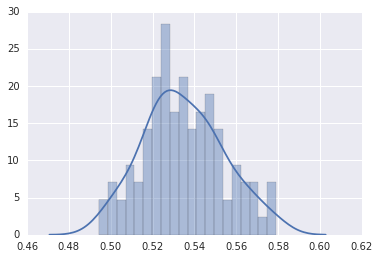

In [16]:
feat = 'BOAW'

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,:codebook],y_train)
#     X = X_train[:,:codebook]
#     y = y_train
    
    model_name = feat+str(idx)+'.'+log_name+'.pkl'
    
    if os.path.isfile(os.path.join(model_dir,model_name)):
        if verbose:
            print("Loading Model",model_name)
        clf = joblib.load(os.path.join(model_dir,model_name)) 
    else:
        clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
                  random_state=rand_state, nu = .5)
        if verbose:
            print("Training SVM %d" % idx)
        clf.fit(X,y)
        joblib.dump(clf,os.path.join(model_dir,model_name))
        
    softScores.append(clf.predict_proba(X_val[:,:codebook]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose=verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

boaw_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    boaw_posteriors+=each
print("Posterior Fusion Score:")
boaw_posteriors /= n_estimators
verboseMetrics(y_val,boaw_posteriors,val_files,thresh=0.664585)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


0.5078878828727007
0.013369782378306813
Posterior Fusion Score:
Threshold selected as 0.713605
TN:61,FP:55,FN:56,TP:60,Sensitivity:0.517241330262,Specificity0.525862019099,Macc:0.52155167468,F1:0.519474970167,AUC:0.543846611177,MCC:0.0431050500093
Threshold selected as 0.713605
[('acc_0', 0.521551724137931)]


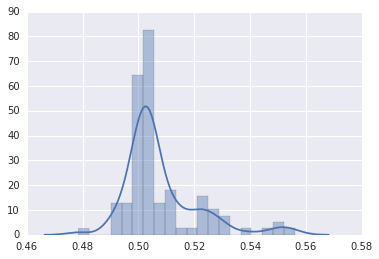

In [120]:
feat = 'fbank'
np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook:codebook+2707],y_train)
#     X = X_train[:,codebook:codebook+2707]
#     y = y_train
    
    model_name = feat+str(idx)+'.'+log_name+'.pkl'
    
    if os.path.isfile(os.path.join(model_dir,model_name)):
        if verbose:
            print("Loading Model",model_name)
        clf = joblib.load(os.path.join(model_dir,model_name)) 
    else:
        clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
                  random_state=rand_state, nu = .5)
        if verbose:
            print("Training SVM %d" % idx)
        clf.fit(X,y)
        joblib.dump(clf,os.path.join(model_dir,model_name))
        
    softScores.append(clf.predict_proba(X_val[:,codebook:codebook+2707]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose=verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

fbank_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    fbank_posteriors+=each
print("Posterior Fusion Score:")
fbank_posteriors /= n_estimators
verboseMetrics(y_val,fbank_posteriors,val_files,thresh='EER')

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

0.47784478227333954
0.011073810865621099
Posterior Fusion Score:
TN:77,FP:39,FN:82,TP:34,Sensitivity:0.293103420482,Specificity0.663793040502,Macc:0.478448230492,F1:0.359783102676,AUC:0.453552318668,MCC:-0.0464098336891
[('acc_0', 0.47844827586206895)]


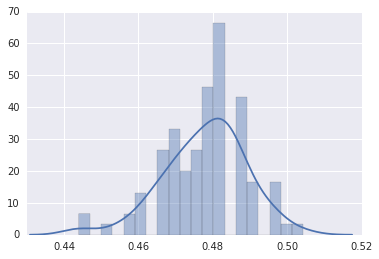

In [71]:
feat = 'ComParE'

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook+2707:],y_train)
#     X = X_train[:,codebook+2707:]
#     y = y_train
    
    model_name = feat+str(idx)+'.'+log_name+'.pkl'
    
    if os.path.isfile(os.path.join(model_dir,model_name)):
        if verbose:
            print("Loading Model",model_name)
        clf = joblib.load(os.path.join(model_dir,model_name)) 
    else:
        clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
                  random_state=rand_state, nu = .5)
        if verbose:
            print("Training SVM %d" % idx)
        clf.fit(X,y)
        joblib.dump(clf,os.path.join(model_dir,model_name))
        3
    softScores.append(clf.predict_proba(X_val[:,codebook+2707:]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose=verbose))
        
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

compare_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    compare_posteriors+=each
print("Posterior Fusion Score:")
compare_posteriors /= n_estimators
verboseMetrics(y_val,compare_posteriors,val_files)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

In [73]:
weights = [.92,.055,.025]

fusedSoft = boaw_posteriors*weights[0]+fbank_posteriors*weights[1]+compare_posteriors*weights[2]
print("Validation accuracy Fusion %f" % accuracy_score(y_val,
                                                            np.argmax(fusedSoft,axis=-1)))
verboseMetrics(y_val,fusedSoft,val_files)

Validation accuracy Fusion 0.551724
TN:85,FP:31,FN:73,TP:43,Sensitivity:0.370689620021,Specificity0.732758551204,Macc:0.551724085612,F1:0.452626295351,AUC:0.586281212842,MCC:0.110977986925
[('acc_0', 0.5517241379310345)]


0.5517240856123712

###### OverSampling

In [123]:
log_name='frac.0'
n_estimators = 5
verbose = False
model_dir = os.path.join('models','oversampling')

0.5249999502155219
0.006334886665096518
Posterior Fusion Score:
Threshold selected as 0.346627
TN:67,FP:49,FN:49,TP:67,Sensitivity:0.577586152125,Specificity0.577586152125,Macc:0.577586152125,F1:0.577580652178,AUC:0.589922711058,MCC:0.155172413793
Threshold selected as 0.346627
[('acc_0', 0.5775862068965517)]


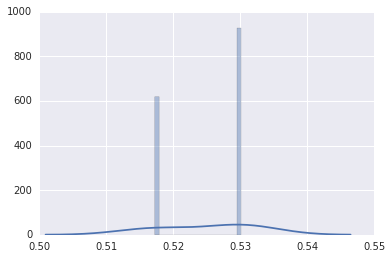

In [93]:
feat = 'BOAW'

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,:codebook],y_train)
    
    model_name = feat+str(idx)+'.'+log_name+'.pkl'
    
    if os.path.isfile(os.path.join(model_dir,model_name)):
        if verbose:
            print("Loading Model",model_name)
        clf = joblib.load(os.path.join(model_dir,model_name)) 
    else:
        clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
                  random_state=rand_state, nu = .5)
        if verbose:
            print("Training SVM %d" % idx)
        clf.fit(X,y)
        joblib.dump(clf,os.path.join(model_dir,model_name))
    
    softScores.append(clf.predict_proba(X_val[:,:codebook]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose=verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

boaw_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    boaw_posteriors+=each
print("Posterior Fusion Score:")
boaw_posteriors /= n_estimators
verboseMetrics(y_val,boaw_posteriors,val_files)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

0.4999999525862114
0.005452202345340082
Posterior Fusion Score:
Threshold selected as 0.999997
TN:54,FP:62,FN:63,TP:53,Sensitivity:0.456896508398,Specificity0.465517197235,Macc:0.461206852817,F1:0.458868915341,AUC:0.461801426873,MCC:-0.0775890900168
Threshold selected as 0.999997
[('acc_0', 0.46120689655172414)]


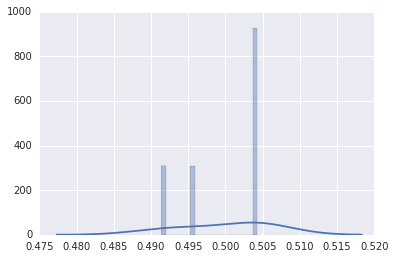

In [124]:
feat = 'fbank'

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook:codebook+2707],y_train)
    
    model_name = feat+str(idx)+'.'+log_name+'.pkl'
    
    if os.path.isfile(os.path.join(model_dir,model_name)):
        if verbose:
            print("Loading Model",model_name)
        clf = joblib.load(os.path.join(model_dir,model_name)) 
    else:
        clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
                  random_state=rand_state, nu = .5)
        if verbose:
            print("Training SVM %d" % idx)
        clf.fit(X,y)
        joblib.dump(clf,os.path.join(model_dir,model_name))
    
    softScores.append(clf.predict_proba(X_val[:,codebook:codebook+2707]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose=verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

fbank_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    fbank_posteriors+=each
print("Posterior Fusion Score:")
fbank_posteriors /= n_estimators
verboseMetrics(y_val,fbank_posteriors,val_files,thresh='EER')

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

0.46982754165428486
0.011882799521536447
Posterior Fusion Score:
TN:83,FP:33,FN:90,TP:26,Sensitivity:0.22413790978,Specificity0.715517173529,Macc:0.469827541654,F1:0.297137903363,AUC:0.453403686088,MCC:-0.0692865572869
[('acc_0', 0.4698275862068966)]


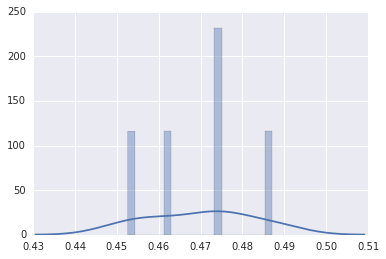

In [91]:
feat = 'ComParE'

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)
    X,y = rus.fit_resample(X_train[:,codebook+2707:],y_train)
    
    model_name = feat+str(idx)+'.'+log_name+'.pkl'
    
    if os.path.isfile(os.path.join(model_dir,model_name)):
        if verbose:
            print("Loading Model",model_name)
        clf = joblib.load(os.path.join(model_dir,model_name))
    else:
        clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
                  random_state=rand_state, nu = .5)
        if verbose:
            print("Training SVM %d" % idx)
        clf.fit(X,y)
        joblib.dump(clf,os.path.join(model_dir,model_name))
    
    softScores.append(clf.predict_proba(X_val[:,codebook+2707:]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose=verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

compare_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    compare_posteriors+=each
print("Posterior Fusion Score:")
compare_posteriors /= n_estimators
verboseMetrics(y_val,compare_posteriors,val_files)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

In [92]:
weights = [.53,.17,.3]

fusedSoft = boaw_posteriors*weights[0]+fbank_posteriors*weights[1]+compare_posteriors*weights[2]
print("Validation accuracy Fusion %f" % accuracy_score(y_val,
                                                            np.argmax(fusedSoft,axis=-1)))
verboseMetrics(y_val,fusedSoft,val_files)

Validation accuracy Fusion 0.491379
TN:72,FP:44,FN:74,TP:42,Sensitivity:0.362068931183,Specificity0.620689596314,Macc:0.491379263749,F1:0.41583616025,AUC:0.532476218787,MCC:-0.0178486076175
[('acc_0', 0.49137931034482757)]


0.49137926374851815

In [ ]:
## Compare

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook+2707:],y_train)
    
    clf = SVC(kernel='linear',probability=True,verbose=verbose=verbose,
              random_state=rand_state, C = 1)
    if verbose:
        print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val[:,codebook+2707:]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

compare_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    compare_posteriors+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,compare_posteriors,val_files)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()